First things first. We need to import all the needed [modules](https://docs.python.org/3/reference/import.html) for this project. Below, I've made a list and described each module and included a link for its website. Typically, to follow along, you just need to `pip install` any of these (for example, `pip install matplotlib`), unless you are using a version of [Anaconda](https://www.anaconda.com/), in which case, you can use `conda install` for any of these modules.

# Modules
- [Numpy](http://www.numpy.org/) is an incredibly powerful tool that is used almost everywhere you encounter matrices in Python. We also use it mainly for its powerful operations on their N-dimensional array objects.

- [Pandas](https://pandas.pydata.org/) is a must for data science in Python. It handles powerful, expressive, and flexible data structures that allow easy data manipulation and analysis (among other things). Main thing to take away are the DataFrames.
- [StatsModels](https://www.statsmodels.org/stable/index.html) is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. It complements SciPy computations providing descriptive statistics and estimation and inference for statistical models.
- [SciPy](https://www.scipy.org/) contains modules for optimization, linear algebra, integration, interpoliation, and much more. Here we will use it mainly for _______.
- [SkLearn](http://scikit-learn.org/stable/) is a Python module for machine learning built on top of SciPy 
- [Math](https://docs.python.org/3/library/math.html) is avaiable by default (i.e. no need to install separately!). This module includes common mathematical functions.
- [Random](https://docs.python.org/3/library/random.html) is a module that generates psuedo-random numbers from various distributions. 
- [Keras](https://keras.io/) is an open source neural network library.
- [Matplotlib](https://matplotlib.org/) is a plotting library. If you're familiar with MATLAB, then this should be familiar as well.
- [Plotly](https://plot.ly/python/) is an interactive, open-source, and browser-based graphing library for Python.


In [4]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
%matplotlib inline

# Data

Now we load up the data and do a little bit of data wrangling. We will load the data into a pandas dataframe and make sure of the following:
1. there are no nulls (if there are, we can figure out what to do then),
2. the format of the data is acceptable (i.e. datetime)
3. bin data as necessary (data will probably come to us in minute/hourly data given the nature of the machine-generated financial data) so we will need to bin the data (for now, we will go with daily updates).

In [29]:
# Let's load up the data into pandas dataframe called data
data = pd.read_csv('./data/bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv')

# We can double check the type of data. It should be dataframe.
type(data)

pandas.core.frame.DataFrame

Great!

Data is loaded into `data`. Note that since we used `pd` (i.e. `pandas`), data is a pandas DataFrame.

As with any data science project, we need to get familar with our data. Let's take a **(1) look at the data** and **(2) clean the data as needed**.
- Check to see if any values are null in the dataframe. Keep in mind, we are looking at financial data that is machine generated, so we're unlikely to have any null values. If we do have any, it would be easy to fill in the gaps using a simple interpolation, but we'll cross that bridge if we have to.
- Take a look at the top 10 rows to look at the value and get a sense of what the data looks like.
- Scale data as needed.

In [16]:
# Are any data points null?
data.isnull().values.any()

False

In [17]:
# What does the first 10 rows look like?
data.head(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
5,1325318220,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
6,1325318280,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
7,1325318340,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
8,1325318400,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
9,1325318460,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


Let's take note of a few things:

1. Take a look at the timestamp. The number you see is a Unix timestamp that captures the number of seconds since epoch (considered to be 1970-01-01 12AM). 
Take for instance, the first row (1325317980). That is equivalent to Saturday, December 31, 2011 7:52:00 AM (GMT) and the second row (1325317980) is the same as Saturday, December 31, 2011 7:53:00 AM. Mainly, notice that it is in the same day. So for the time being, we will look at data partitioned by day, so we're going to need to get the average price grouped by the day.
2. We want to change the timestamp into a human readable datetime format.

In [18]:
#First we create a new column called "date" then we group by and grab the average
data['date'] = pd.to_datetime(data['Timestamp'],unit='s').dt.date
group = data.groupby('date')
Daily_Price = group['Weighted_Price'].mean()

# let's take a look at the first 5
Daily_Price.head()

date
2011-12-31    4.472579
2012-01-01    4.680778
2012-01-02    5.000000
2012-01-03    5.145917
2012-01-04    5.195443
Name: Weighted_Price, dtype: float64

In [19]:
#and the last 5
Daily_Price.tail()

date
2018-06-23    6135.489772
2018-06-24    6024.179869
2018-06-25    6202.747358
2018-06-26    6201.548412
2018-06-27    6069.787707
Name: Weighted_Price, dtype: float64

## Split our dataset

We need to **split our dataset** because we want to train and test the model only on some chunk of the data. So, in the next cell, we are counting the necessary parameters for splitting (number of days between some dates). We want to train our model on the data from January 1, 2016, until March 1, 2018, and to test the model on the data from March 1, 2018, until June 27, 2018.

In [40]:
from datetime import date

d0 = date(2016, 1, 1)
d1 = date(2018, 6, 27)
delta = d1 - d0
days_look = delta.days + 1
print("days between", d0, "and", d1, ":", days_look)

d0 = date(2018, 3, 1)
d1 = date(2018, 6, 27)
delta = d1 - d0
days_from_train = delta.days + 1
print("days between", d0, "and", d1, ":", days_from_train)

d0 = date(2018, 6, 27)
d1 = date(2018, 6, 27)
delta = d1 - d0
days_from_end = delta.days + 1
print("days between", d0, "and", d1, ":", days_from_end)

days between 2016-01-01 and 2018-06-27 : 909
days between 2018-03-01 and 2018-06-27 : 119
days between 2018-06-27 and 2018-06-27 : 1


In [45]:
#Now we are splitting our data into the train and test set:

df_train= Daily_Price[len(Daily_Price)-days_look-days_from_end:len(Daily_Price)-days_from_train]
df_test= Daily_Price[len(Daily_Price)-days_from_train:]

print(len(df_train), len(df_test))

791 119


# Cursory Data Analysis

We want to estimate some parameters of our data because this can be useful in the further model designing. The first important thing when forecasting time series is to check if the data is stationary. This means that our data is influenced by such factors as trend or seasonality.

In the next cell, we concatenate train and test data to make analysis and transformations simultaneously.

In [43]:
working_data = [df_train, df_test]
working_data = pd.concat(working_data)

working_data = working_data.reset_index()
working_data['date'] = pd.to_datetime(working_data['date'])
working_data = working_data.set_index('date')

In the next couple of cells, we perform a seasonal decomposition of the data to estimate its trend and seasonality. You can see the actual price movements on the plot below (“observed”) as well as the trend and seasonality in our data.

In [44]:
s = sm.tsa.seasonal_decompose(working_data.Weighted_Price.values, freq=60)

trace1 = go.Scatter(x = np.arange(0, len(s.trend), 1),y = s.trend,mode = 'lines',name = 'Trend',
    line = dict(color = ('rgb(244, 146, 65)'), width = 4))
trace2 = go.Scatter(x = np.arange(0, len(s.seasonal), 1),y = s.seasonal,mode = 'lines',name = 'Seasonal',
    line = dict(color = ('rgb(66, 244, 155)'), width = 2))

trace3 = go.Scatter(x = np.arange(0, len(s.resid), 1),y = s.resid,mode = 'lines',name = 'Residual',
    line = dict(color = ('rgb(209, 244, 66)'), width = 2))

trace4 = go.Scatter(x = np.arange(0, len(s.observed), 1),y = s.observed,mode = 'lines',name = 'Observed',
    line = dict(color = ('rgb(66, 134, 244)'), width = 2))

data = [trace1, trace2, trace3, trace4]
layout = dict(title = 'Seasonal decomposition', xaxis = dict(title = 'Time'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='seasonal_decomposition')

The next thing we do is the examination of the autocorrelation. It is it is the similarity between observations as a function of the time lag between them. It is important for finding repeating patterns in the data.



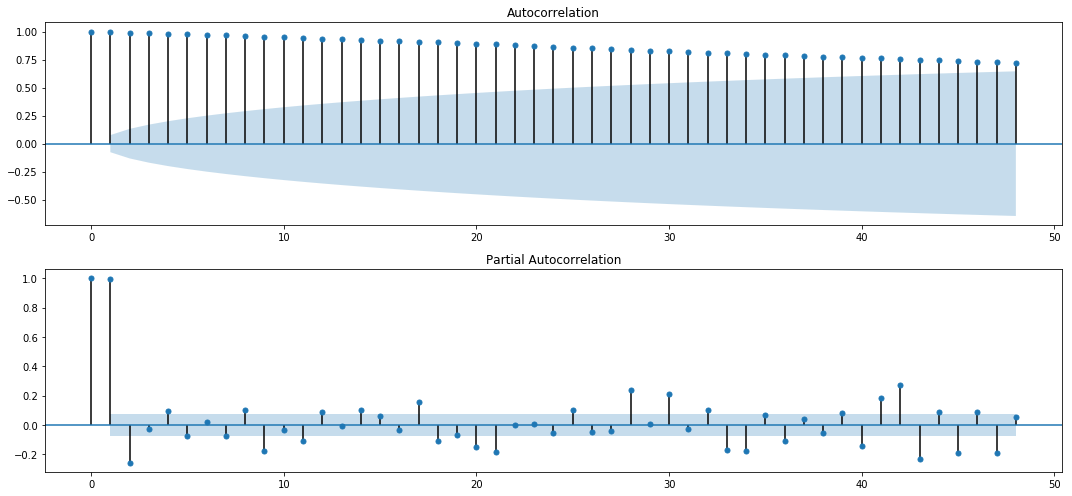

In [24]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(working_data.Weighted_Price.values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(working_data.Weighted_Price.values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

Now we need to recover our df_train and df_test datasets:



In [26]:
df_train = working_data[:-60]
df_test = working_data[-60:]


# Data Preparation
We need to prepare our dataset according to the requirements of the model, as well as to split the dataset into train and test parts. In the next cell, we define a function which creates X inputs and Y labels for our model. In the sequential forecasting, we predict the future value based on some previous and current values. So, our Y label is the value from the next (future) point of time while the X inputs are one or several values from the past. The amount of these values we can set by tuning the parameter look_back in our function. If we set it to 1, this means that we predict current value t based on the previous value (t-1).



In [27]:
def create_lookback(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

Now we perform final data preparation:

Reshape the train and test datasets according to the requirements of the model.
Scale the dataset by using the MinMaxScaler because LSTM models are scale sensitive.
Apply our create_lookback function.

In [28]:
from sklearn.preprocessing import MinMaxScaler

training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
test_set = df_test.values
test_set = np.reshape(test_set, (len(test_set), 1))

#scale datasets
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
test_set = scaler.transform(test_set)

# create datasets which are suitable for time series forecasting
look_back = 1
X_train, Y_train = create_lookback(training_set, look_back)
X_test, Y_test = create_lookback(test_set, look_back)

 # reshape datasets so that they will be ok for the requirements of the LSTM model in Keras
X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

We have tried to train several different models and compare their results. You can find them in the table below. These results were obtained using the following hardware: 4-core CPU, 16 GB RAM and by training each model ten times with different random states. As we can see, the best result is obtained by using the 2-stacked LSTM. Nevertheless, this model is much slower then GRU or 1-layer LSTM. The Autoregressive integrated moving average model (ARIMA) shows the worst results both in performance and training time. We can also see, that the 1-layer LSTM model is not capable to recognize patterns in the data so we need more complex models. We are going to demonstrate 2-layers LSTM neural network in more detail.

